# Butler Interface for User

The point of this notebook is to do step-by-step exploration of the DEEP dataset that was first run through KBMOD for the first set of papers. That work was led by Hayden Smotherman, hence the reference to that name.

The "Steven" name that appears is Steven Stetzler, who inherited the responsibilities of properly re/processing the entire DEEP dataset through data acquired through 2023.

### Basic Idea
Here we are connecting to an existing Butler/repository with the intent of carrying out queries to find data suitable for KBMOD to use.

#### FAQ

Q: Who wrote this, and when?\
A: Colin Orion Chandler (coc123@uw.edu), late January 2024.

Q: What are the basic requirements to run this?\
A: (a) Epyc access, (b) with the appropriate (LSST w_2022_06) weekly build active, (c) permissions to access the repo_path mentioned below, and (d) an acceptable Kernel in the Jupyter-Hub of Epyc (user or global).

Q: Why don't we just query the DB (e.g., PostGres, SQLite) to get what we need?\
A: Because (a) the underlying schema can (and has/does) change, and (b) the underlying DB does not contain views, meaning that we would have to recreate the very complex relational mapping ourselves. Moreover, aside from (b) being very challenging, the relationship mapping recreation would fail due to the reasons mentioned in (a).

### Initial Setup

In [215]:
# Import packages needed to run the notebook
import lsst
import lsst.daf.butler as dafButler
import os
import time
from matplotlib import pyplot as plt
import progressbar
from concurrent.futures import ProcessPoolExecutor, as_completed
from astropy.time import Time  # for converting Butler visitInfo.date (TAI) to UTC strings
import pandas as pd

In [136]:
# We will use multiprocessing in a few places. Let's see what the sytsem thinks we have available.
import multiprocessing

multiprocessing.cpu_count()

96

In [2]:
# this code will run in different environments, so we need somewhere (not the working directory) to save output
basedir = f'{os.environ["HOME"]}/kbmod_tmp'
os.makedirs(basedir, exist_ok=True)

In [3]:
# set up the Butler
# NOTE: the repo path contains configs that point us to the underlying registry (DB)
# NOTE: do NOT assume there is write protection! (i.e., don't make changes)
repo_path = f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
butler = dafButler.Butler(repo_path)

#### Collections
1. Explore the available collections
2. Construct a list of the collections containing the data we care about.

Different collections hold different datasets.

For the Hayden DEEP repo, the collections we are concerned with are organized by pointing groups (discrete regions on the sky).

We want to figure out what those are, how they are named, and what else is available.

We will also dump a full list of collection names to disk. \
NOTE: as of 2/1/2024, there are 1,292 named collections in the repo.


In [153]:
all_collection_names = []

for c in sorted(butler.registry.queryCollections("*")):
    all_collection_names.append(c)

outfile = f"{basedir}/all_collection_names.lst"
with open(outfile, "w") as f:
    for c in all_collection_names:
        print(c, file=f)

print(f'Found {len(all_collection_names)} collections in the Butler. Wrote to "{outfile}".')

Found 1292 collections in the Butler. Wrote to "/astro/users/coc123/kbmod_tmp/all_collection_names.lst".


In [154]:
# We looked through the collections already.
# We will string manipulate to get to what we need.
# Previously, I used a list file on disk. (This could be a better option for some users.)

desired_collections = []  # we will store these for future use

for collection_name in all_collection_names:
    if "Pointing" in collection_name and "/imdiff_r" in collection_name and "/2021" not in collection_name:
        desired_collections.append(collection_name)
desired_collections

['PointingGroup006/imdiff_r',
 'PointingGroup008/imdiff_r',
 'PointingGroup009/imdiff_r',
 'PointingGroup016/imdiff_r',
 'PointingGroup018/imdiff_r',
 'PointingGroup019/imdiff_r',
 'PointingGroup021/imdiff_r',
 'PointingGroup023/imdiff_r']

In [11]:
# ASIDE: there is a set of collections with dates in their names
#   (e.g., PointingGroup006/imdiff_r/20211110T184421Z).
# Those (only?) have the following datasetTypes, (so we use the name without the date for all the datasetTypes):
# Across all collections, we see the following numbers by datasetType:
# 47383      deepDiff_diaSrc
# 8          deepDiff_diaSrc_schema
# 47383      deepDiff_differenceExp
# 29445      deepDiff_warpedExp
# 8          imageDifference_config
# 17942      imageDifference_log
# 47383      imageDifference_metadata
# 8          packages

# which is too little? we we will snag the parent Collections (stripping dates)

#### datasetTypes

Here we explore another dimension of the Butler: datasetType.

tldr; we just care about one currently: deepDiff_differenceExp

In [169]:
# TIMING NOTE: about 2 minutes here
#
# Maybe a KBMOD user must know which datasetType(s) they need?
# Here we show how to explore them to figure that out.
#
# NOTE: we tested two approaches,
#   (a) iterating over desired_collections, and
#   (b) supply desired_collections.
# The output was the same, but the iterating method took 268s, and the supplied method took 97s.
# There *was* a point where we thought we were seeing different results depending on the approach,
# but this has been sorted out. (COC suspects a testing break in a loop somwhere.)
# COC NTS: [TODO] function, [TODO] caching


def getDatasetTypeStats(butler, overwrite=False):
    """
    Get information on all datasetTypes found in a Butler.
    TODO implement caching if desired. If not, get rid of overwrite option.
    2/1/2024 COC
    """
    datasetTypes = {}

    import glob

    cache_file = f"{basedir}/dataset_types.csv"
    cache_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_exists = True

    if overwrite == False and cache_exists == True:
        print(f"Recycling {cache_file} as overwrite was False...")
        with open(cache_file, "r") as f:
            for line in f:
                print(line)
                line = line.strip().split(",")
                datasetTypes[line[0]] = int(line[1])
        print(f"Read {len(datasetTypes)} datasetTypes from disk.")
        return datasetTypes

    q = sorted(butler.registry.queryDatasetTypes())

    with progressbar.ProgressBar(max_value=len(q)) as bar:
        for j, dt in enumerate(q):
            n = 0
            for i, ref in enumerate(
                butler.registry.queryDatasets(datasetType=dt, collections=desired_collections)
            ):
                n += 1
            if n > 0:
                if dt.name not in datasetTypes:
                    datasetTypes[dt.name] = 0
                datasetTypes[dt.name] += n
            bar.update(j)

    if cache_exists == False or overwrite == True:
        print(f"Saving {len(datasetTypes)} datasetTypes to {cache_file} now...")
        with open(cache_file, "w") as f:
            for key in datasetTypes:
                print(f"{key},{datasetTypes[key]}", file=f)
    else:
        print(f"Saw {len(datasetTypes)} datasetTypes.")
    return datasetTypes

In [170]:
%%time
datasetTypes = getDatasetTypeStats(butler=butler, overwrite=False)

100% (129 of 129) |######################| Elapsed Time: 0:02:28 Time:  0:02:28


Saving 46 datasetTypes to /astro/users/coc123/kbmod_tmp/dataset_types.csv now...
CPU times: user 1min 57s, sys: 2.96 s, total: 2min
Wall time: 2min 28s


In [8]:
# The number of records for each datasetType.
# This may be especially useful for users who do not yet know which datasetType(s) they need.

print(f"Across all collections, we see the following numbers by datasetType: ")
for dt in datasetTypes:
    print(f"{datasetTypes[dt]!s:10} {dt.name}")

Across all collections, we see the following numbers by datasetType: 
8          assembleCoadd_config
268        assembleCoadd_log
700        assembleCoadd_metadata
122856     cal_ref_cat
47403      calexp
47403      calexpBackground
8          calibrate_config
17961      calibrate_log
47403      calibrate_metadata
8          characterizeImage_config
18290      characterizeImage_log
47423      characterizeImage_metadata
693        deepCoadd
167085     deepCoadd_directWarp
693        deepCoadd_inputMap
167085     deepCoadd_psfMatchedWarp
47383      deepDiff_diaSrc
8          deepDiff_diaSrc_schema
47383      deepDiff_differenceExp
29445      deepDiff_warpedExp
524283     gaia_DR1_v1
47423      icExp
47423      icExpBackground
47423      icSrc
8          icSrc_schema
8          imageDifference_config
17942      imageDifference_log
47383      imageDifference_metadata
8          isr_config
18290      isr_log
48422      isr_metadata
8          makeWarp_config
64924      makeWarp_log
167085 

In [9]:
# This is the datasetType that we care about.
# NOTE: we should allow this to be a list in case a user needs multiple.
desired_datasetTypes = ["deepDiff_differenceExp"]

### Visit Detector Region (VDR) Querying

Here we will query the Butler and extract all of the "visit_detector_region" information.\
At this stage we are gathering:
1. dataIds for all future queries
2. lsst.sphgeom.region objects

In [213]:
%%time
# VDR === Visit Detector Region
# VDRs hold what we need in terms of region hashes and unique dataIds.
# NOTE: this typically takes < 5s to run 2/1/2024 COC
# NOTE: tried iterating over desired_collections vs supplying desired_collections; same output 2/1/2024 COC

vdr_ids = []
vdr_regions = []
vdr_detectors = []

for dt in desired_datasetTypes:
    datasetRefs = butler.registry.queryDimensionRecords(
        "visit_detector_region", datasets=dt, collections=desired_collections
    )
    for ref in datasetRefs:
        vdr_ids.append(ref.dataId)
        vdr_regions.append(ref.region)  # keeping as objects for now; should .encode() for caching/export
        vdr_detectors.append(ref.detector)  # 2/2/2024 COC
        # BUT if we decided to export this or cache this, we should write the encode() version to disk
        #
        tmpref = ref  # this leaves a VDR Python object we can play with
        # other data available:
        #    id = ref.id# id -- e.g., 1592350 (for DEEP dataset, I think UUIDs for newer Butlers)
        #    visit = ref.dataId.full['visit'] # e.g., 946725
        # vdr_filters.append(ref.dataId.full['band']) # e.g., VR
        # vdr_detectors.append(ref.dataId.full['detector']) # e.g., 1

CPU times: user 1.64 s, sys: 85.7 ms, total: 1.72 s
Wall time: 2.38 s


In [12]:
print(f"We found {len(vdr_ids)} regions spanning the {len(desired_collections)} desired collections.")

We found 47383 regions spanning the 8 desired collections.


In [212]:
# For demonstration purposes we still have the last "ref" from the last cell's iteration
tmpref

visit_detector_region.RecordClass(instrument='DECam', detector=62, visit=946176, region=ConvexPolygon([UnitVector3d(0.9876086828694174, -0.13336028508776862, -0.08272922024438323), UnitVector3d(0.9873378171284917, -0.13332652431396907, -0.08595389916869185), UnitVector3d(0.9881047366097594, -0.12752395595185462, -0.08594573955553172), UnitVector3d(0.9883760335240734, -0.12755303452468866, -0.0827226676235914)]))

In [14]:
# This is the unique dataId we would need to retrieve this specific image later
tmpref.dataId

{instrument: 'DECam', detector: 62, visit: 946176}

In [15]:
# The unique dataId is made up of the following attributes:
print(
    f"tmpref.instrument = {tmpref.instrument}, tmpref.detector = {tmpref.detector}, tmpref.visit = {tmpref.visit}"
)

tmpref.instrument = DECam, tmpref.detector = 62, tmpref.visit = 946176


In [16]:
# This is the region hash we would use for "region matching" later
tmpref.region.encode()

b'p\xddnE\x86}\x9a\xef?\x0f\xc3\x84\'\xf3\x11\xc1\xbf\x80\x8a_\xff\xbd-\xb5\xbf\x04xUzE\x98\xef?\x94\x15\xcf\xf2\xd7\x10\xc1\xbf\x9d\xa9\xe4!\x13\x01\xb6\xbf\x1d_\x18\xd3\x8d\x9e\xef?\x80\x87"z\xb4R\xc0\xbff\x1d\x9f<\x8a\x00\xb6\xbf\xe4Z\x84\xc6\xc6\xa0\xef?\x1f\x01\xe5g\xa8S\xc0\xbf\xba\xc9\x14\x10P-\xb5\xbf'

In [140]:
# We check to see if we can crawl to other data from the dataId (False means no).
tmpref.dataId.hasRecords()

False

### Instrument handling
Some Butler queries require the instrument to be specified.\
For now, we are just supplying the one we care about (KLUDGE).\
It's a list so we can mix-and-match shift-and-stack across instruments(!).\
NOTE: will leave this as a list for future-proofing purpose

In [164]:
# [TODO] extract this somehow automatically 2/1/2024 COC
# desired_instruments = ['DECam']

In [176]:
def getInstruments(butler, first_instrument_only=True):
    """Iterate through our records to determine which instrument(s) are involved.
    Return a list of the identified instruments.
    If first_instrument_only is True, stop as soon as we found an instrument.
    """
    # KLUDGE: snag the instrument name of the first record we find in a visitInfo query.
    instrument_names = []
    for i, dataId in enumerate(vdr_ids):
        visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
        instrument_name = visitInfo.instrumentLabel
        if instrument_name not in instrument_names:
            print(f'Found {instrument_name}. Adding to "desired_instruments" now.')
            instrument_names.append(instrument_name)
        if first_instrument_only == True and len(instrument_names) > 0:
            print(
                f"WARNING: we are not iterating over all rows to find instruments, just taking the first one."
            )
            break
    return instrument_names

In [177]:
%%time
desired_instruments = getInstruments(butler=butler)

Found DECam. Adding to "desired_instruments" now.
CPU times: user 85.5 ms, sys: 8.04 ms, total: 93.5 ms
Wall time: 126 ms


### Butler Retrieval Example

A quick stop to see how we can grab the full Butler record via a dataId.

In [143]:
%%time
# Back to the dataId, we can actually fetch the image from the Butler
# NOTE: it takes about 1 second to do this, so we won't be able to do this at scale

tmp = butler.get(desired_datasetTypes[0], collections=desired_collections, dataId=tmpref.dataId)

CPU times: user 864 ms, sys: 221 ms, total: 1.09 s
Wall time: 1.5 s


In [146]:
tmp.detector.getId()

62

In [149]:
tmp.filterLabel.bandLabel

'VR'

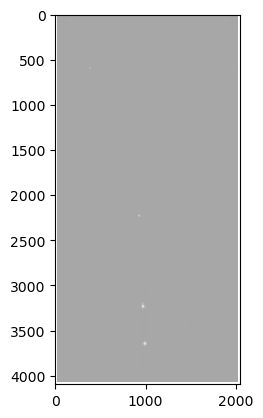

In [19]:
# we can even view the image right here
plt.imshow(tmp.image.array, cmap="gray")

In [20]:
# There IS a WCS here, which we did not see in the earlier VDR
tmp.wcs

FITS standard SkyWcs:
Sky Origin: (352.4630539808, -4.8516830845)
Pixel Origin: (1126.14, 1991.36)
Pixel Scale: 0.262593 arcsec/pixel

In [180]:
# We can access all kinds of metadata this way.
# NOTE: keywords are source data-dependent.
# NOTE: this linkage works with butler.get() but not necessarily elsewhere.
meta = tmp.getInfo().getMetadata()

print(f"Here are all the keywords available from this image:")
for k in meta.keys():
    print(k)

Here are all the keywords available from this image:
NEXTEND
PROCTYPE
PRODTYPE
PIXSCAL1
PIXSCAL2
FILENAME
TELESCOP
OBSERVAT
INSTRUME
EXPREQ
OBSID
TIME-OBS
OPENSHUT
EXPNUM
OBJECT
OBSTYPE
CAMSHUT
PROGRAM
OBSERVER
PROPOSER
DTPI
PROPID
EXCLUDED
SEQID
SEQNUM
SEQTOT
AOS
BCAM
GUIDER
SKYSTAT
FILTER
INSTANCE
ERRORS
TELEQUIN
TELSTAT
RA
DEC
TELRA
TELDEC
HA
ZD
AZ
DOMEAZ
ZPDELRA
ZPDELDEC
TELFOCUS
VSUB
GSKYPHOT
LSKYPHOT
WINDSPD
WINDDIR
PRESSURE
DIMMSEE
DIMM2SEE
MASS2
ASTIG1
ASTIG2
OUTTEMP
AIRMASS
GSKYVAR
GSKYHOT
LSKYVAR
LSKYHOT
LSKYPOW
MSURTEMP
MAIRTEMP
UPTRTEMP
LWTRTEMP
PMOSTEMP
UTN-TEMP
UTS-TEMP
UTW-TEMP
UTE-TEMP
PMN-TEMP
PMS-TEMP
PMW-TEMP
PME-TEMP
DOMELOW
DOMEHIGH
DOMEFLOR
G-MEANX
G-MEANY
DONUTFS4
DONUTFS3
DONUTFS2
DONUTFS1
G-FLXVAR
G-MEANXY
DONUTFN1
DONUTFN2
DONUTFN3
DONUTFN4
TIME_RECORDED
G-FEEDBK
G-CCDNUM
DOXT
G-MAXX
FADZ
FADY
FADX
G-MODE
FAYT
DODZ
DODY
DODX
MULTIEXP
SKYUPDAT
G-SEEING
G-TRANSP
G-MEANY2
DOYT
G-LATENC
LUTVER
FAXT
G-MAXY
G-MEANX2
SISPIVER
CONSTVER
HDRVER
DTPROPID
DTCALDAT
DTSITE


### URI / URL / Path Handling
Here we grab URIs for the dataIds we need.

In [152]:
%%time

# this is the single-thead approach; wanted 2 hours to executed

doIt = False
if doIt == True:
    paths = []
    with progressbar.ProgressBar(max_value=len(vdr_ids)) as bar:
        for i, dataId in enumerate(vdr_ids):
            my_path = butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections)
            paths.append(my_path)
            bar.update(i)
# no progress bar (my original approach)
# paths = [butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections) for dataId in vdr_ids]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 14.3 µs


In [63]:
%%time

# TODO: functionize

paths = []

# vdr_ids[0:1000] took 20s, chunking by 100;
# vdr_ids[0:100] with chunking by 10 took 8 s
subset = vdr_ids  # doing all with chunksize of 200 took 83s!

# thank you ChatGPT 4 for helping parallelize

from concurrent.futures import ProcessPoolExecutor, as_completed
import progressbar


# Function to divide vdr_ids into chunks of 100
def chunked_dataIds(dataIds, chunk_size=200):
    """Yield successive chunk_size chunks from dataIds."""
    for i in range(0, len(dataIds), chunk_size):
        yield dataIds[i : i + chunk_size]


# The function that will be executed in parallel, now adjusted to handle a list of dataIds
def get_uris(dataIds_chunk):
    # Initialize an empty list to store URIs for this chunk
    chunk_uris = []
    # You might need to reinitialize the Butler instance here if it's not serializable or shareable across processes
    butler = dafButler.Butler(repo_path)
    for dataId in dataIds_chunk:
        try:
            uri = butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections)
            uri = uri.geturl()  # just the text please
            chunk_uris.append(uri)
        except Exception as e:
            print(f"Failed to retrieve path for dataId {dataId}: {e}")
    return chunk_uris


# Use ProcessPoolExecutor to execute get_uris in parallel processes
with ProcessPoolExecutor() as executor:
    # Prepare your dataId chunks
    dataId_chunks = list(chunked_dataIds(subset))

    # Initialize progress bar
    with progressbar.ProgressBar(max_value=len(dataId_chunks)) as bar:
        futures = {executor.submit(get_uris, chunk): chunk for chunk in dataId_chunks}

        paths = []
        for i, future in enumerate(as_completed(futures)):
            # Retrieve the result of the future, which is the list of URIs for the chunk
            uris = future.result()
            paths.extend(uris)  # Add the retrieved URIs to the main list
            bar.update(i)

# At this point, `paths` will contain all successfully retrieved URIs for the chunks processed

100% (237 of 237) |######################| Elapsed Time: 0:01:03 Time:  0:01:03


CPU times: user 1.42 s, sys: 3.65 s, total: 5.08 s
Wall time: 1min 21s


In [64]:
# make sure the number of paths we generated matches the number of vdr_ids
len(paths) == len(vdr_ids)

True

In [66]:
# example URI
paths[0]

'file:///epyc/users/smotherh/DEEP/PointingGroups/butler-repo/PointingGroup008/imdiff_r/20210803T142852Z/deepDiff_differenceExp/20190829/VR/VR_DECam_c0007_6300.0_2600.0/891505/deepDiff_differenceExp_DECam_VR_VR_DECam_c0007_6300_0_2600_0_891505_N28_PointingGroup008_imdiff_r_20210803T142852Z.fits'

# Timestamp Handling Section
Here we will access the timestamp (datetime) information from the Butler for our records.

In [138]:
# Now we want to get metadata like datetime, exposure time, etc.
for i, dataId in enumerate(vdr_ids):
    visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
    print(i, visitInfo.date, visitInfo.exposureTime, visitInfo.boresightRaDec)
    break
# We have the visitInfo object for the exploration below.

0 DateTime("2019-09-27T00:20:59.932016000", TAI) 120.0 (351.3806941054, -5.2403083277)


In [134]:
# That visitInfo.date format may not look familiar. Let's find out why:
type(visitInfo.date)

lsst.daf.base.dateTime.dateTime.DateTime

In [139]:
# Let's convert to a plain string, UTC (handles 37 s offset).
t = Time(testing, format="isot", scale="tai")
str(t.utc)

'2019-09-27T00:20:22.932'

In [126]:
def getTimestamps(dataIds, overwrite=False):
    """Get timestamps for a bunch of dataIds.
    Convert the LSST/Butler TAI to UTC in the process.
    Do this all in a chunked, multiprocessing way.
    Takes about 3 minutes as of 2/1/2024 (Hayden DEEP).
    BUT if we have the values cached, just read those instead, unless overwrite is True.
    2/1/2024 COC
    """
    # thank you ChatGPT 4 for helping parallelize

    timestamps = []

    import glob

    cache_file = f"{basedir}/vdr_timestamps.lst"

    cache_file_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_file_exists = True

    if overwrite == False and cache_file_exists == True:
        print(f"Overwrite is False, so we will read the timestamps from file now...")
        with open(cache_file, "r") as f:
            for line in f:
                timestamps.append(line.strip())
        print(f"Recycled {len(timestamps)} from {cache_file}.")
        return timestamps

    # Function to divide vdr_ids into chunks of 100
    def chunked_dataIds(dataIds, chunk_size=200):
        """Yield successive chunk_size chunks from dataIds."""
        for i in range(0, len(dataIds), chunk_size):
            yield dataIds[i : i + chunk_size]

    # The function that will be executed in parallel, now adjusted to handle a list of dataIds
    def get_timestamps(dataIds_chunk):
        # Initialize an empty list to store URIs for this chunk
        chunked_data = []
        # You might need to reinitialize the Butler instance here if it's not serializable or shareable across processes
        butler = dafButler.Butler(repo_path)
        for dataId in dataIds_chunk:
            try:
                visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
                t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
                tutc = str(t.utc)
                chunked_data.append(tutc)
            except Exception as e:
                print(f"Failed to retrieve timestamp for dataId {dataId}: {e}")
        return chunked_data

    # Use ProcessPoolExecutor to execute get_uris in parallel processes
    with ProcessPoolExecutor() as executor:
        # Prepare your dataId chunks
        dataId_chunks = list(chunked_dataIds(dataIds))

        # Initialize progress bar
        with progressbar.ProgressBar(max_value=len(dataId_chunks)) as bar:
            futures = {executor.submit(get_timestamps, chunk): chunk for chunk in dataId_chunks}

            paths = []
            for i, future in enumerate(as_completed(futures)):
                # Retrieve the result of the future, which is the list of URIs for the chunk
                timestamps = future.result()
                timestamps.extend(timestamps)  # Add the retrieved URIs to the main list
                bar.update(i)

    if overwrite == True or cache_file_exists == False:
        with open(cache_file, "w") as f:
            for ts in timestamps:
                print(ts, file=f)
        print(f"Wrote {len(timestamps)} lines to {cache_file} for future use.")

    print(f"Obtained {len(timestamps)} timestamps.")
    return timestamps

In [128]:
%%time
vdr_timestamps = getTimestamps(dataIds=vdr_ids, overwrite=False)

Overwrite is False, so we will read the timestamps from file now...
Recycled 47383 from /astro/users/coc123/kbmod_tmp/vdr_timestamps.lst.
CPU times: user 13.5 ms, sys: 10.7 ms, total: 24.2 ms
Wall time: 23.4 ms


In [272]:
# NOTE: getURIs() does not work as you'd think (i.e., it only handles a single dataId)
# butler.getURIs(desired_datasetTypes[0], vdr_ids, collections=desired_collections)

### Working with the Regions

We still don't know what will be ideal to do for Region Search.\
So, to start with, we will work on extract the (RA, Dec) of the (1) center coordinate of a chip, and (2) four corners associated with a chip.

#### We will start with corners (i.e., quadilateral vertices from the convexPolygon sphgeom.regions)

In [183]:
def getRegionCorners(region):
    """
    Using the 2D boundingBox() from an input region (convexPolygon), we
    extract the (RA, Dec) coordinates of each vertex.
    As there are four vertices, the input object is a quadrilateral.
    2/2/2024 COC
    """
    corners = []
    bbox = region.getBoundingBox()
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getB().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getB().asDegrees()))
    return corners

In [194]:
# Example
corners = getRegionCorners(tmpref.region)
corners

[(352.30950511932116, -4.930880058593892),
 (352.30950511932116, -4.7450820235469715),
 (352.64644359666477, -4.930880058593892),
 (352.64644359666477, -4.7450820235469715)]

In [190]:
def getMinMaxRaDec(ra_dec_touples, verbose=False):
    """
    Highly unoptimized way to find and return
    (minRA, maxRA) and (minDec, MaxDec).
    2/2/2024 COC
    """
    min_ra = min([i[0] for i in ra_dec_touples])
    min_dec = min([i[1] for i in ra_dec_touples])
    max_ra = max([i[0] for i in ra_dec_touples])
    max_dec = max([i[1] for i in ra_dec_touples])
    if verbose:
        print(f"RA range: {min_ra} to {max_ra}")
        print(f"Dec range: {min_dec} to {max_dec}")
    return (min_ra, max_ra), (min_dec, max_dec)

In [195]:
# Example
getMinMaxRaDec(ra_dec_touples=corners)

((352.30950511932116, 352.64644359666477),
 (-4.930880058593892, -4.7450820235469715))

#### Centers

It may be easer to just work with center (RA, Dec) coordinates.\
We can later store this in a DB (e.g., Postgres) for cone searches.

In [181]:
def getCenterRaDec(region):
    """
    We pull the 2D boundingBox (not the boundingBox3d) from a region.
    Then we extract the center's (RA, Dec) coordinates.
    2/2/2024 COC
    """
    bbox_center = region.getBoundingBox().getCenter()
    ra = bbox_center.getLon().asDegrees()
    dec = bbox_center.getLat().asDegrees()
    return (ra, dec)

In [182]:
getCenterRaDec(tmpref.region)

(352.477974357993, -4.837981041070432)

In [192]:
%%time
vdr_centers = [getCenterRaDec(i) for i in vdr_regions]

CPU times: user 483 ms, sys: 99.9 ms, total: 583 ms
Wall time: 1.1 s


In [193]:
len(vdr_centers)

47383

In [195]:
vdr_centers[0]

(351.0694028401149, -4.336598368890197)

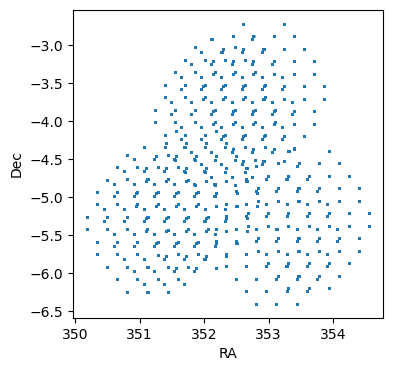

In [196]:
# Let us visualize where on the sky our chip centers reside
fig = plt.figure(figsize=(4, 4))
plt.xlabel("RA")
plt.ylabel("Dec")
plt.scatter([i[0] for i in vdr_centers], [i[1] for i in vdr_centers], s=1, alpha=0.5)

The DECam mosaic shape is clearly visible, thrice.\
There is an offset from each of the three pointings, too.

In the most simple approach, each of these "dots" represents a set of images that can be fed to KBMOD.

In [214]:
# NEXT WE WILL ASSEMBLE A DATAFRAME

In [219]:
%%time
df_dict = {}
df_dict["data_id"] = vdr_ids
df_dict["ut"] = vdr_timestamps
df_dict["detector"] = vdr_detectors
df_dict["center_coord"] = vdr_centers
# df_dict['region'] = vdr_regions # still mulling this over, maybe we do not need full objects 2/2/2024 COC

df = pd.DataFrame.from_dict(df_dict)

In [221]:
df

,data_id,ut,detector,center_coord
0,"(instrument, detector, visit)",2019-09-27T00:20:22.932,1,"(351.0694028401149, -4.336598368890197)"
1,"(instrument, detector, visit)",2019-09-27T00:22:51.015,1,"(351.0695696334572, -4.336293374423113)"
2,"(instrument, detector, visit)",2019-09-27T00:25:19.136,1,"(351.0696571334576, -4.336293374415341)"
3,"(instrument, detector, visit)",2019-09-27T00:27:47.118,1,"(351.069611300124, -4.336293374419411)"
4,"(instrument, detector, visit)",2019-09-27T00:30:15.537,1,"(351.0695696451088, -4.336265319377865)"
...,...,...,...,...
47378,"(instrument, detector, visit)",2020-10-17T03:33:36.950,62,"(352.4779285369392, -4.838007985003787)"
47379,"(instrument, detector, visit)",2020-10-17T03:36:05.017,62,"(352.4778993579928, -4.83798104107715)"
47380,"(instrument, detector, visit)",2020-10-17T03:38:33.955,62,"(352.47792852465943, -4.837981041074541)"
47381,"(instrument, detector, visit)",2020-10-17T03:41:03.154,62,"(352.47792852465943, -4.837981041074541)"


In [223]:
# look at the first dataId, which does not show up in a pretty way in the DF
df["data_id"].iloc[0]

{instrument: 'DECam', detector: 1, visit: 898286}

In [226]:
df62 = df[df["detector"] == 62]
df62

,data_id,ut,detector,center_coord
5644,"(instrument, detector, visit)",2019-08-29T07:16:03.693,62,"(351.69307656022727, -6.143624107225388)"
5645,"(instrument, detector, visit)",2019-08-29T07:18:31.270,62,"(351.6932430489372, -6.143319112795237)"
5646,"(instrument, detector, visit)",2019-08-29T07:20:59.790,62,"(351.69333054893764, -6.143319112787463)"
5647,"(instrument, detector, visit)",2019-08-29T07:23:27.901,62,"(351.69328471560397, -6.143319112791537)"
5648,"(instrument, detector, visit)",2019-08-29T07:25:55.714,62,"(351.6932430325679, -6.143291057753383)"
...,...,...,...,...
47378,"(instrument, detector, visit)",2020-10-17T03:33:36.950,62,"(352.4779285369392, -4.838007985003787)"
47379,"(instrument, detector, visit)",2020-10-17T03:36:05.017,62,"(352.4778993579928, -4.83798104107715)"
47380,"(instrument, detector, visit)",2020-10-17T03:38:33.955,62,"(352.47792852465943, -4.837981041074541)"
47381,"(instrument, detector, visit)",2020-10-17T03:41:03.154,62,"(352.47792852465943, -4.837981041074541)"


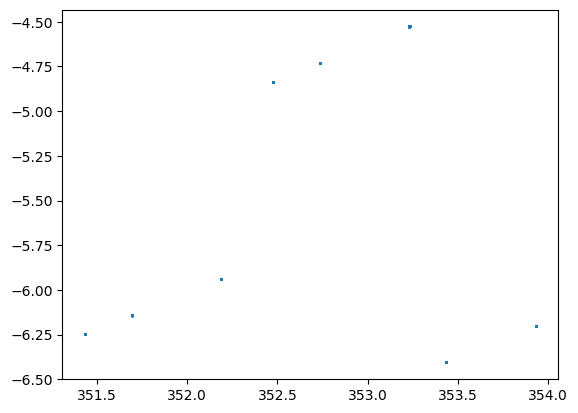

In [235]:
plt.clf()
plt.scatter(*zip(*df62["center_coord"]), s=1, alpha=0.5)

In [237]:
# chip62_coord0 = df62['center_coord'][0]

### Region Matching
Here region matching means comparing two lsst.sphgeom.region objects.\
Purpose: to see if they have any overlap whatsoever. \
NOTE: a partial or full overlap is called an "intersection" in sphgeom lingo.

NOTE: Work in progress, but pausing this avenue for now. 2/2/2024 COC

In [216]:
# manual region-region matching between all chips
# NOTE: estimate time is 1 hour, so skipping this for now

doit = False
if doit == True:
    lastTime = time.time()

    matches = {}

    with progressbar.ProgressBar(max_value=len(vdr_regions)) as bar:
        for i, l in enumerate(vdr_regions):
            my_id = vdr_ids[i]
            matches[my_id] = []
            for j, r in enumerate(vdr_regions):
                if i == j:
                    continue
                if l.intersects(r):
                    matches[my_id].append(vdr_ids[j])
            bar.update(i)
    elapsed = round(time.time() - lastTime, 1)
    print(f"It took {elapsed} seconds.")

  3% (1468 of 47383) |                   | Elapsed Time: 0:01:39 ETA:   0:52:55


KeyboardInterrupt: 

### HTM Exploration

In [202]:
# Colin playing 1/15/2024 COC
def getHTMstuff(ra, dec, level=7, verbose=False):
    """
    1/16/2024 COC inception.
    A function that
        1. Fetches an HTM ID for a pixelization of a user-supplied level.
        2. Determines the angular size (radius, in arcseconds) of the pixelization level.
    LSST stores the unique HTM ID for level 7 pixelization in the Butler, hence the default level=7.
    """
    pixelization = lsst.sphgeom.HtmPixelization(level)

    try:  # kludges; use the Butler way, but if being passed normal numbers, use those
        ra = ra.asDegrees()
    except AttributeError as msg:
        pass
    try:
        dec = dec.asDegrees()
    except AttributeError as msg:
        pass

    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            # sphgeom.LonLat.fromDegrees(ra.asDegrees(), dec.asDegrees())
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees() * 3600.0
    level = pixelization.getLevel()
    if verbose:
        print(f"HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.")
    return (htm_id, scale)

In [204]:
getHTMstuff(vdr_centers[0][0], vdr_centers[0][1], verbose=True)

HTM ID=189361 at level=7 is bounded by a circle of radius ~1895.11 arcsec.


(189361, 1895.111766130883)

In [238]:
dsRefs = butler.registry.queryDatasets(
    datasetType=desired_datasetTypes[0], htm7=147116, collections=desired_collections
)
print(len(sorted(dsRefs)))

0


### Brute force approach for (small) discrete datasets

The idea here is that we can organize piles of images.

In [271]:
from astropy import units as u


def find_overlapping_coords(df, uncertainty_radius):
    df_copy = df.copy()

    # Assuming uncertainty_radius is provided as a float in arcseconds
    uncertainty_radius_as = uncertainty_radius * u.arcsec

    all_coords = SkyCoord(
        ra=[x[0] for x in df_copy["center_coord"]] * u.degree,
        dec=[x[1] for x in df_copy["center_coord"]] * u.degree,
    )

    overlapping_sets = {}
    set_counter = 1
    processed_data_ids = []

    with progressbar.ProgressBar(max_value=len(all_coords)) as bar:

        for index, coord in enumerate(all_coords):
            data_id = df_copy.iloc[index]["data_id"]
            if data_id not in processed_data_ids:
                distances = (
                    coord.separation(all_coords).to(u.arcsec).value
                )  # Convert distances to arcseconds as numeric values

                # Perform comparison as numeric values, bypassing direct unit comparison
                within_radius = (distances <= uncertainty_radius_as.value) & (distances > 0)

                if any(within_radius):
                    overlapping_indices = [
                        i
                        for i, distance in enumerate(distances)
                        if (distance <= uncertainty_radius_as.value) and i != index
                    ]
                    overlapping_data_ids = df_copy.iloc[overlapping_indices]["data_id"].tolist()
                    overlapping_data_ids.append(data_id)

                    processed_data_ids.extend(overlapping_data_ids)

                    overlapping_sets[f"set_{set_counter}"] = overlapping_data_ids
                    set_counter += 1
            bar.update(index)

    return overlapping_sets

In [272]:
%%time
overlapping_sets = find_overlapping_coords(df=df62, uncertainty_radius=30)

100% (781 of 781) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.23 s


In [267]:
len(overlapping_sets)

8

In [268]:
overlapping_sets

{'set_1': [{instrument: 'DECam', detector: 62, visit: 898287},
  {instrument: 'DECam', detector: 62, visit: 898288},
  {instrument: 'DECam', detector: 62, visit: 898289},
  {instrument: 'DECam', detector: 62, visit: 898290},
  {instrument: 'DECam', detector: 62, visit: 898291},
  {instrument: 'DECam', detector: 62, visit: 898292},
  {instrument: 'DECam', detector: 62, visit: 898293},
  {instrument: 'DECam', detector: 62, visit: 898294},
  {instrument: 'DECam', detector: 62, visit: 898295},
  {instrument: 'DECam', detector: 62, visit: 898296},
  {instrument: 'DECam', detector: 62, visit: 898297},
  {instrument: 'DECam', detector: 62, visit: 898298},
  {instrument: 'DECam', detector: 62, visit: 898299},
  {instrument: 'DECam', detector: 62, visit: 898300},
  {instrument: 'DECam', detector: 62, visit: 898301},
  {instrument: 'DECam', detector: 62, visit: 898302},
  {instrument: 'DECam', detector: 62, visit: 898303},
  {instrument: 'DECam', detector: 62, visit: 898304},
  {instrument: 'DEC

In [273]:
%%time

# TIMING NOTE: this takes about 1.25 hours(?) [TODO update that number]
# [TODO] caching
overlapping_sets = find_overlapping_coords(df=df, uncertainty_radius=30)

 53% (25405 of 47383) |#########         | Elapsed Time: 0:40:26 ETA:   1:07:25IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73% (34916 of 47383) |#############     | Elapsed Time: 1:15:02 ETA:   0:49:16IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 85% (40710 of 47383) |###############   | Elapsed Time: 1:41:13 ETA:   0:34:17IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to a

In [274]:
len(overlapping_sets)

488